In [2]:
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
# from train_generator import batch_iterator, random_rotate, random_image_shift
# from utils.util import train_progressbar, slack_message
# from config import TRAIN_FILE, TEST_FILE
import os
import random
import cv2

from config import *
from iterator import DataGenerator

In [2]:
from skimage.exposure import equalize_adapthist
import skimage

In [3]:
import skimage
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import rescale, resize, downscale_local_mean, rotate

## function define

In [4]:
def image_loader(f):
    return skimage.io.imread(f)

In [5]:
def crop_optic_disk(img,mk, margin = 3):
    img_shape = img.shape
    h = np.where(mk>0)[0]
    h = int(mk.shape[0]/2) if h.size == 0 else h
        
    w = np.where(mk>0)[1]
    w = int(mk.shape[1]/2) if w.size == 0 else w
    
    maxh = min(np.unique(h)[-2]+margin, mk.shape[0])
    minh = max(np.unique(h)[3]-margin, 0)
    maxw = min(np.unique(w)[-2]+margin, mk.shape[1])
    minw = max(np.unique(w)[3]-margin, 0)
    
    img = img[minh:maxh,minw:maxw,:]
    img = resize(img, img_shape)
    return img

In [6]:
def resize_image(img,shape):
    img = resize(img,shape)
    return img

In [7]:
def cleaner(mak, ignore =1):
    idx = []
    tmp = np.pad(mak,3,mode = 'constant', constant_values=0)[:,:,3:6]
    for i in range(tmp.shape[0]-3):
        for j in range(tmp.shape[1]-3):
            if np.sum(tmp[i:i+3,j:j+3,:]> 100) <= ignore*3 :
                idx.append((i,j,3))
    for (i,j,_) in idx:
        tmp[i:i+3,j:j+3,:] = np.zeros((3,3,3))
    return tmp[3:-3,3:-3,:]

In [8]:
def normalize_img(img):
    shape = img.shape
    img = np.float64(img.reshape(-1))
    img -= img.mean()
    img /= img.std()
    img = img.reshape(shape)
#     img = img/ 255
    return img

## Generator

In [9]:
# gen = DataGenerator(TRAIN_IMAGE, MASK_LOC,2,IMAGE_SHAPE,OPTIC_DISC_SHAPE,is_train=True,copy=True,sample = 20)
gen = DataGenerator(TEST_IMAGE, MASK_LOC
                                  ,2,IMAGE_SHAPE, OPTIC_DISC_SHAPE
                                  ,is_train=False, copy = True, sample=20)

 [>>__________________________________________________________________________________________________] 20 Done

In [10]:
# gen.get_batch(154)[0][3]

C:\Users\infinigru\Anaconda3\envs\prac\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


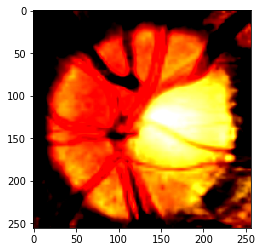

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


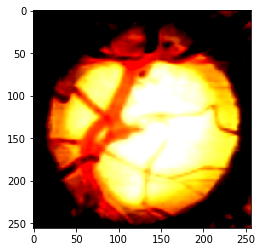

[1.]
1


In [11]:
item, y_true = gen[1] #V0217.jpg V0127.jpg
plt.imshow(item[0])
plt.show()
print(y_true[0])
# print(name[0])
plt.imshow(item[1])
plt.show()
print(y_true[1])
# print(name[1])
print(gen.idx)

In [8]:
import numpy as np
y_true = np.array([[0.],[0.]])
y_pred = np.array([[0.1],[0.8]])

In [80]:
gen.initialize()

## cleaning mask data

In [82]:
test = 'V0125'
im = os.path.join(TEST_IMAGE,'Glaucoma',test+'.jpg')
ma = os.path.join(MASK_LOC,'mask_'+test+'.jpg')

In [87]:
img = image_loader(im)
img = resize_image(img,(512,512,3))
mak = image_loader(ma)
# mak = cleaner(mak,1)

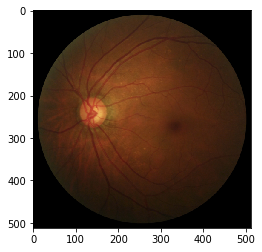

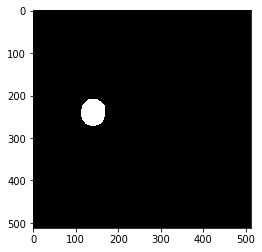

In [88]:
plt.imshow(img)
plt.show()
plt.imshow(mak)
plt.show()

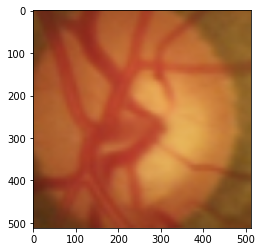

In [89]:
plt.imshow(crop_optic_disk(img,mak,3))

In [569]:
cv2.imwrite(ma,mak)

True

## segment generator

In [12]:
import numpy as np
# import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
import skimage
from seg_iterator import DataGenerator
import cv2
from config import *

In [13]:
from config import *

In [14]:
train_iterator = DataGenerator(TRAIN_IMAGE, MASKING_VAL_IMAGE
                                   ,1
                                   ,IMAGE_SHAPE, is_train=True,sample = None)

 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13 Done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


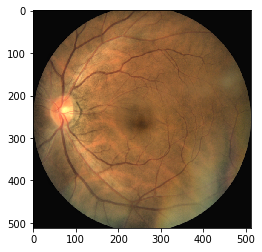

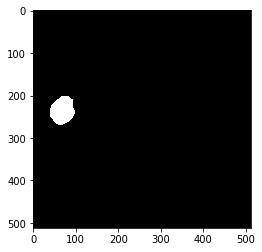

In [33]:
train_images, train_labels = train_iterator.get_item()
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0].reshape((512,512)), cmap='gray', vmin=0, vmax=1)
plt.show()

In [29]:
train_iterator.initialize()

In [34]:
import collections
collections.Counter(train_labels[0].flatten())

Counter({0.0: 259164, 1.0: 2980})